<span style="color:red; font-family:Georgia; font-size:1.5em;">
    Leveraging Machine Learning to Analyse Football Data and Make Predictions</span>

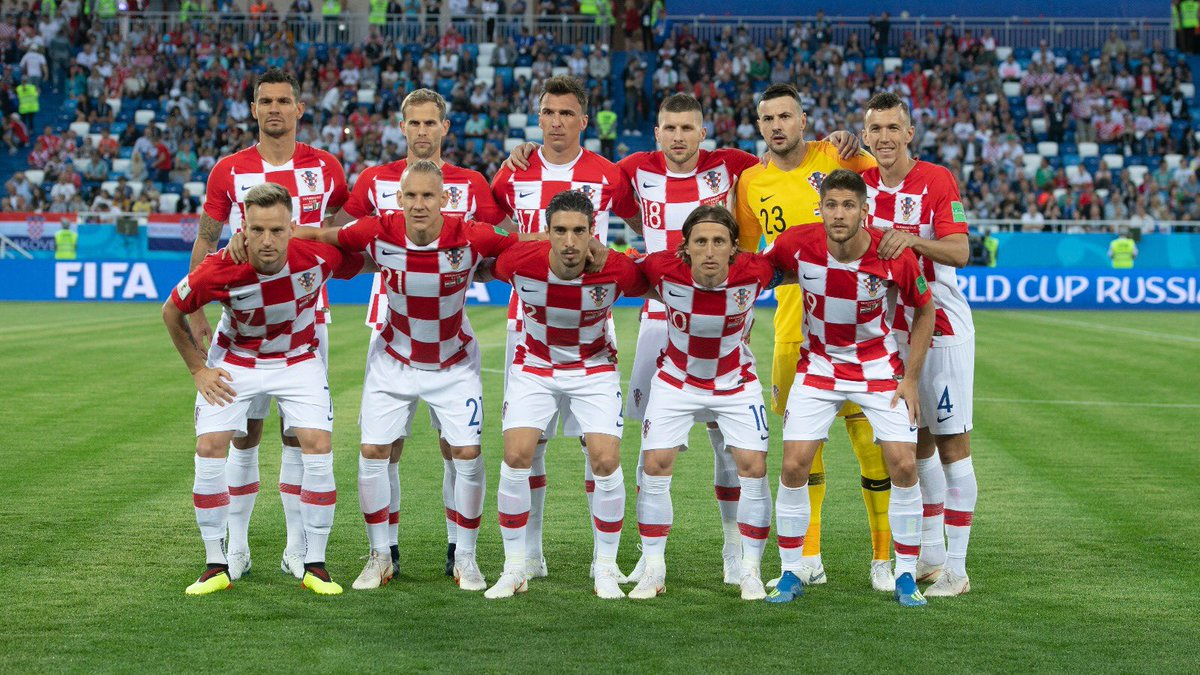

In [1]:
"""Importing the necessary libraries for the project. 
Pandas, numpy, and matplotlib are the standard data science libraries, 
and seaborn and plotly are for data visualization. The code also imports 
the necessary libraries to display images, videos, math equations, and markdown. 
datetime is for working with dates and times. warnings allows for warnings to be suppressed. 
And mpimg is for displaying images."""

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from IPython.display import Markdown as md
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from datetime import datetime
import warnings
import matplotlib.image as mpimg

# Data Cleaning 

This description code provides information about matches and results. The date column is present in all the files and is used to link the different types of data together.  The other columns provide information about the match, such as the date, home_team, away_team, home_score, away_score, tournament, city, country, and whether the match was played at a neutral venue.

- date - date of the match
- home_team - the name of the home team
- away_team - the name of the away team
- home_score - full-time home team score including extra time, not including penalty-shootouts
- away_score - full-time away team score including extra time, not including penalty-shootouts
- tournament - the name of the tournament
- city - the name of the city/town/administrative unit where the match was played
- country - the name of the country where the match was played
- neutral - TRUE/FALSE column indicating whether the match was played at a neutral venue

In [2]:
# Dataset "International football results from 1872 to 2022"
results = pd.read_csv("results.csv") 

# Dataset "FIFA World Ranking 1992-2022" 
ranking = pd.read_csv("fifa_ranking-2022.csv")

In [3]:
# from object to datetime64[ns] 
results["date"] = pd.to_datetime(results["date"])
ranking["rank_date"] = pd.to_datetime(ranking["rank_date"])

## results

- we will use the last 2 years

In [4]:
#  filtering the results dataframe to only include rows with a date after 1/1/2020, 
# then resetting the index, and finally dropping the columns "city" and "country".

results = results[(results["date"] >= "2020-1-1")].reset_index(drop=True)
results = results.drop(["city","country"], axis=1) 

In [5]:
# Checking the dataset 'results' and calculates the sum of all the null values within it. 
# It returns the total number of null values as an integer

results.isnull().sum()    

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
neutral       0
dtype: int64

In [6]:
results.replace("United States", "USA", inplace=True)

In [7]:
# This code iterates through the columns of the 'results' dataframe and 
# prints out the unique values of each column.

"""for i in results.columns:
    print(results[i].unique()) """

'for i in results.columns:\n    print(results[i].unique()) '

## ranking

In [8]:
"""This code is sorting the ranking dataframe based on the rank column in ascending order 
and then filtering out the rows where the rank_date is greater than or equal to "2022-10-06". 
The drop() method is then used to remove the columns 'previous_points','rank_change','confederation', 
and 'rank_date' from the dataframe."""

ranking.sort_values(by="rank",inplace=True)
# using the last ranking
ranking = ranking[ranking["rank_date"]>="2022-10-06"].drop([
    "previous_points","rank_change","confederation","rank_date"], axis=1)       

In [9]:
ranking.replace("Türkiye", "Turkey", inplace=True)
ranking.replace(['Korea Republic', 'Korea DPR'], 'South Korea', inplace=True)

In [10]:
"""This code checks for the number of null or missing values in the 'ranking' dataframe 
 and returns the count."""

ranking.isnull().sum()   

rank            0
country_full    0
country_abrv    0
total_points    0
dtype: int64

In [11]:
# This code resets the index of the 'ranking' dataframe, and then drops the resulting "index" column.
ranking = ranking.reset_index().drop("index", axis=1)  

# Merge 

In [12]:
"""This code is performing a left merge between the 'results' and 'ranking' dataframes 
using the 'home_team' column from 'results' and the 'country_full' column from 'ranking'. 
It is then dropping the 'country_full' and 'country_abrv' columns from the merged dataframe, 
and renaming the 'rank' and 'total_points' columns to 'rank_home_team' and 'points_home_team' 
respectively."""

m_1 = results.merge(ranking, how="left", left_on='home_team', 
                    right_on='country_full',suffixes=('_left', '_right')) 
m_1.drop(["country_full","country_abrv"], axis=1, inplace=True)
m_1.rename(columns={'rank':'rank_home_team' ,'total_points':'points_home_team'}, inplace=True) 

In [13]:
"""This code is merging two datasets, m_1 and ranking, on the columns "away_team" and "country_full".
It is then dropping the columns "country_full" and "country_abrv" and renaming the columns "rank" 
and "total_points" to "rank_away_team" and "points_away_team". Finally, the code is displaying 
the new columns."""

m_2 = m_1.merge(ranking, how="left", left_on='away_team', 
                    right_on='country_full',suffixes=('_left', '_right'))
m_2.drop(["country_full","country_abrv"], axis=1, inplace=True)
m_2.rename(columns={'rank':'rank_away_team' ,'total_points':'points_away_team'}, inplace=True) 
m_2.columns 

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'neutral', 'rank_home_team', 'points_home_team',
       'rank_away_team', 'points_away_team'],
      dtype='object')

In [14]:
order = ['date', 'home_team', 'home_score', 'rank_home_team', 'points_home_team', 
        'away_team', 'away_score', 'rank_away_team', 'points_away_team', 
        'tournament', 'neutral']

m_2 = m_2[order] 

In [15]:
"""looping through two columns of a dataframe, comparing the values, and adding 
a new column to the dataframe with a corresponding value (2, 0, or 1). 
2 indicates a win, 0 indicates a loss, and 1 indicates a tie."""

win = []
for h, a in zip(m_2['home_score'], m_2['away_score']):
    if h > a:
        win.append(2)
    if a > h:
        win.append(0)
    if a == h:
        win.append(1)
m_2['win'] = win 

In [16]:
"""This code is finding the home teams with less than 12 games played from the dataframe 'm_2' 
by grouping the data by home_team, counting the number of rows for each team, sorting the data 
by the home_score column and then selecting the teams with less than 12 games played by 
selecting the index values from the dataframe 'drops'."""

drops = m_2.groupby("home_team").count().sort_values(by="home_score")
drops[drops["date"]<12].index.unique()

Index(['Somalia', 'Saint Martin', 'Seychelles', 'Cook Islands',
       'New Caledonia', 'Turkmenistan', 'Taiwan', 'Aymara', 'Basque Country',
       'French Guiana',
       ...
       'Mali', 'Lebanon', 'Rwanda', 'Tanzania', 'Trinidad and Tobago',
       'Thailand', 'Australia', 'Ghana', 'Malawi', 'Oman'],
      dtype='object', name='home_team', length=112)

In [17]:
""" This code is dropping specific rows (specified by list_A) in the dataframe m_2. 
Specifically, it is removing all rows in m_2 where the 'home_team' values are present 
in the list_A array. This is done by locating all the rows that fulfill this condition 
and then dropping them from the dataframe."""

list_A = drops[drops["date"]<12].index.unique() 
m_2 = m_2.drop(m_2[m_2['home_team'].isin(list_A)].index)

In [18]:
m_2.isnull().sum()

date                 0
home_team            0
home_score           0
rank_home_team      28
points_home_team    28
away_team            0
away_score           0
rank_away_team      47
points_away_team    47
tournament           0
neutral              0
win                  0
dtype: int64

In [19]:
m_2[m_2['points_away_team'].isnull().values == True]["home_team"].unique()

array(['Andorra', 'Belgium', 'Uzbekistan', 'Burkina Faso', 'Japan',
       'Morocco', 'Bosnia and Herzegovina', 'Niger', 'Mozambique',
       'Nepal', 'Guatemala', 'Tunisia', 'Bahrain', 'Senegal',
       'El Salvador', 'Kuwait', 'Canada', 'Costa Rica', 'USA', 'Iraq',
       'United Arab Emirates', 'Indonesia', 'Nigeria', 'Cameroon',
       'Syria', 'Ethiopia', 'South Korea', 'France', 'England', 'Panama',
       'Ecuador', 'Wales'], dtype=object)

In [20]:
# Now we can drop the NaN values 
m_2.dropna(inplace=True)

# Exploring the data

In [21]:
m_2.head() 

,date,home_team,home_score,rank_home_team,points_home_team,away_team,away_score,rank_away_team,points_away_team,tournament,neutral,win
1,2020-01-09,Moldova,0,174.0,961.23,Sweden,1,25.0,1553.33,Friendly,True,0
3,2020-01-12,Kosovo,0,107.0,1187.01,Sweden,1,25.0,1553.33,Friendly,True,0
4,2020-01-15,Canada,0,41.0,1475.00,Iceland,1,62.0,1384.41,Friendly,True,0
5,2020-01-19,El Salvador,0,74.0,1330.51,Iceland,1,62.0,1384.41,Friendly,True,0
6,2020-02-01,USA,1,16.0,1627.48,Costa Rica,0,31.0,1503.59,Friendly,False,2


In [22]:
m_2.corr().style.background_gradient()

,home_score,rank_home_team,points_home_team,away_score,rank_away_team,points_away_team,neutral,win
home_score,1.000000,-0.220480,0.233487,-0.188556,0.314107,-0.313483,-0.089541,0.605620
rank_home_team,-0.220480,1.000000,-0.982500,0.243133,0.399731,-0.392363,-0.032746,-0.258486
points_home_team,0.233487,-0.982500,1.000000,-0.241481,-0.404987,0.399629,0.033806,0.265337
away_score,-0.188556,0.243133,-0.241481,1.000000,-0.273539,0.287013,0.025694,-0.645802
rank_away_team,0.314107,0.399731,-0.404987,-0.273539,1.000000,-0.985895,-0.016331,0.314109
points_away_team,-0.313483,-0.392363,0.399629,0.287013,-0.985895,1.000000,0.004815,-0.328287
neutral,-0.089541,-0.032746,0.033806,0.025694,-0.016331,0.004815,1.000000,-0.076829
win,0.605620,-0.258486,0.265337,-0.645802,0.314109,-0.328287,-0.076829,1.000000


Text(0.5, 1.0, 'TOP 15 TYPE OF MATCH TOURNAMENTS')

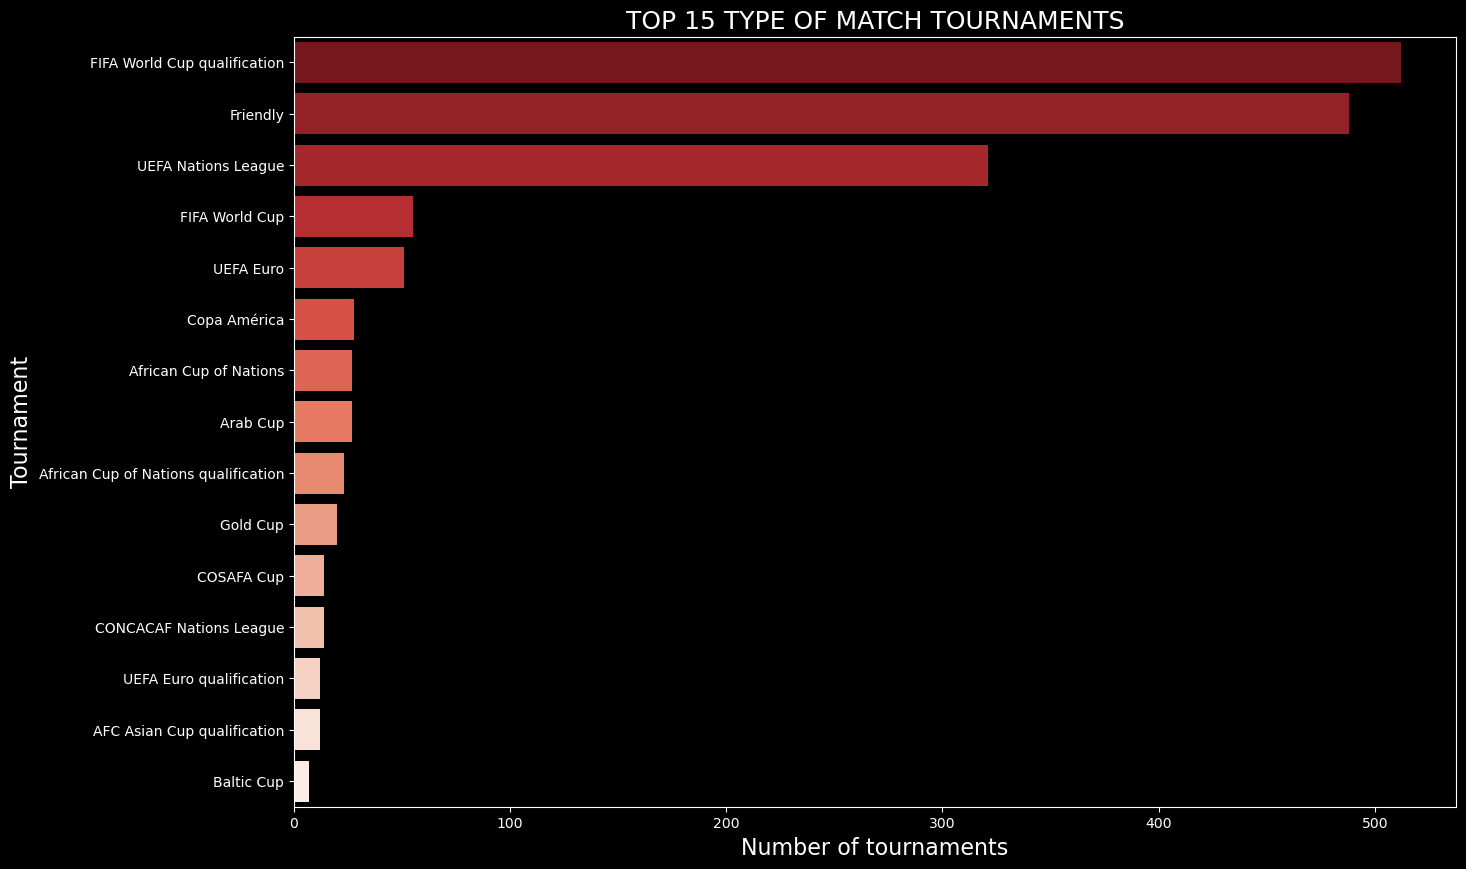

In [23]:
"""This is a great example of code that produces a barplot with 15 types of matches used for
a project. The plt.style.use('dark_background') line adds a nice touch to the graph, making it 
look more visually appealing. The variables, labels, and title are all intuitive and descriptive, 
allowing readers to quickly understand the context of the graph."""

plt.style.use('dark_background')

# getting the barplot with 15 types of matches we used for the project
tournament = m_2['tournament'].value_counts()
tournament = tournament[:15]
plt.figure(figsize = (15,10))
ax = sns.barplot(y=tournament.index, x=tournament.values, palette="Reds_r", orient='h')
ax.set_ylabel('Tournament', size=16)
ax.set_xlabel('Number of tournaments', size=16)
ax.set_title("TOP 15 TYPE OF MATCH TOURNAMENTS", fontsize=18)

In [24]:
"""This code snippet adds the columns 'winner' and 'loser' to the dataframe 'm_2' 
and populates the values in these columns based on the 'home_score', 'away_score', 
'home_team' and 'away_team' columns. The code compares the values in 'home_score' 
and 'away_score' and populates the 'winner' and 'loser' columns accordingly. If 
the values are equal, then 'draw' is added to both the columns."""

# defining two empty lists that we will use for winn : lose ratio
win = []
los = []
for h, a, ht, at in zip(m_2['home_score'], m_2['away_score'], m_2['home_team'], m_2['away_team']):
    if h > a:
        win.append(ht)
        los.append(at)
    if a > h:
        win.append(at)
        los.append(ht) 
    if a == h:
        win.append("draw")
        los.append("draw") 
# adding new columns in m_2
m_2['winner'] = win
m_2['loser'] = los


In [25]:
"""This code looks at a dataframe m_2 and calculates the win-lose ratio for each player by 
counting the number of wins and losses for each player. It takes the win column from the 
winner groupby, adds it to the win column from the loser groupby, and then divides the win 
column from the winner groupby by that sum. Finally, the output is sorted in descending order 
by the win_lose_ratio column, and the win_lose_ratio column is returned."""

# making win_lose_ratio dataframe
plot_1_winner = m_2.groupby("winner").count()
plot_1_loser = m_2.groupby("loser").count()
plot_1_winner["win_lose_ratio"] = plot_1_winner["win"] / (plot_1_winner["win"] + plot_1_loser["win"])
plot_1_winner = pd.DataFrame(plot_1_winner.sort_values(by="win_lose_ratio", ascending=False)["win_lose_ratio"]) 
plot_1_winner 

,win_lose_ratio
winner,
Argentina,0.960000
Brazil,0.933333
Morocco,0.916667
Algeria,0.857143
Netherlands,0.851852
...,...
Liechtenstein,0.142857
Gibraltar,0.142857
Lebanon,0.125000


,win_lose_ratio
count,123.000000
mean,0.488808
std,0.205400
min,0.125000
25%,0.333333
50%,0.500000
75%,0.644269
max,0.960000


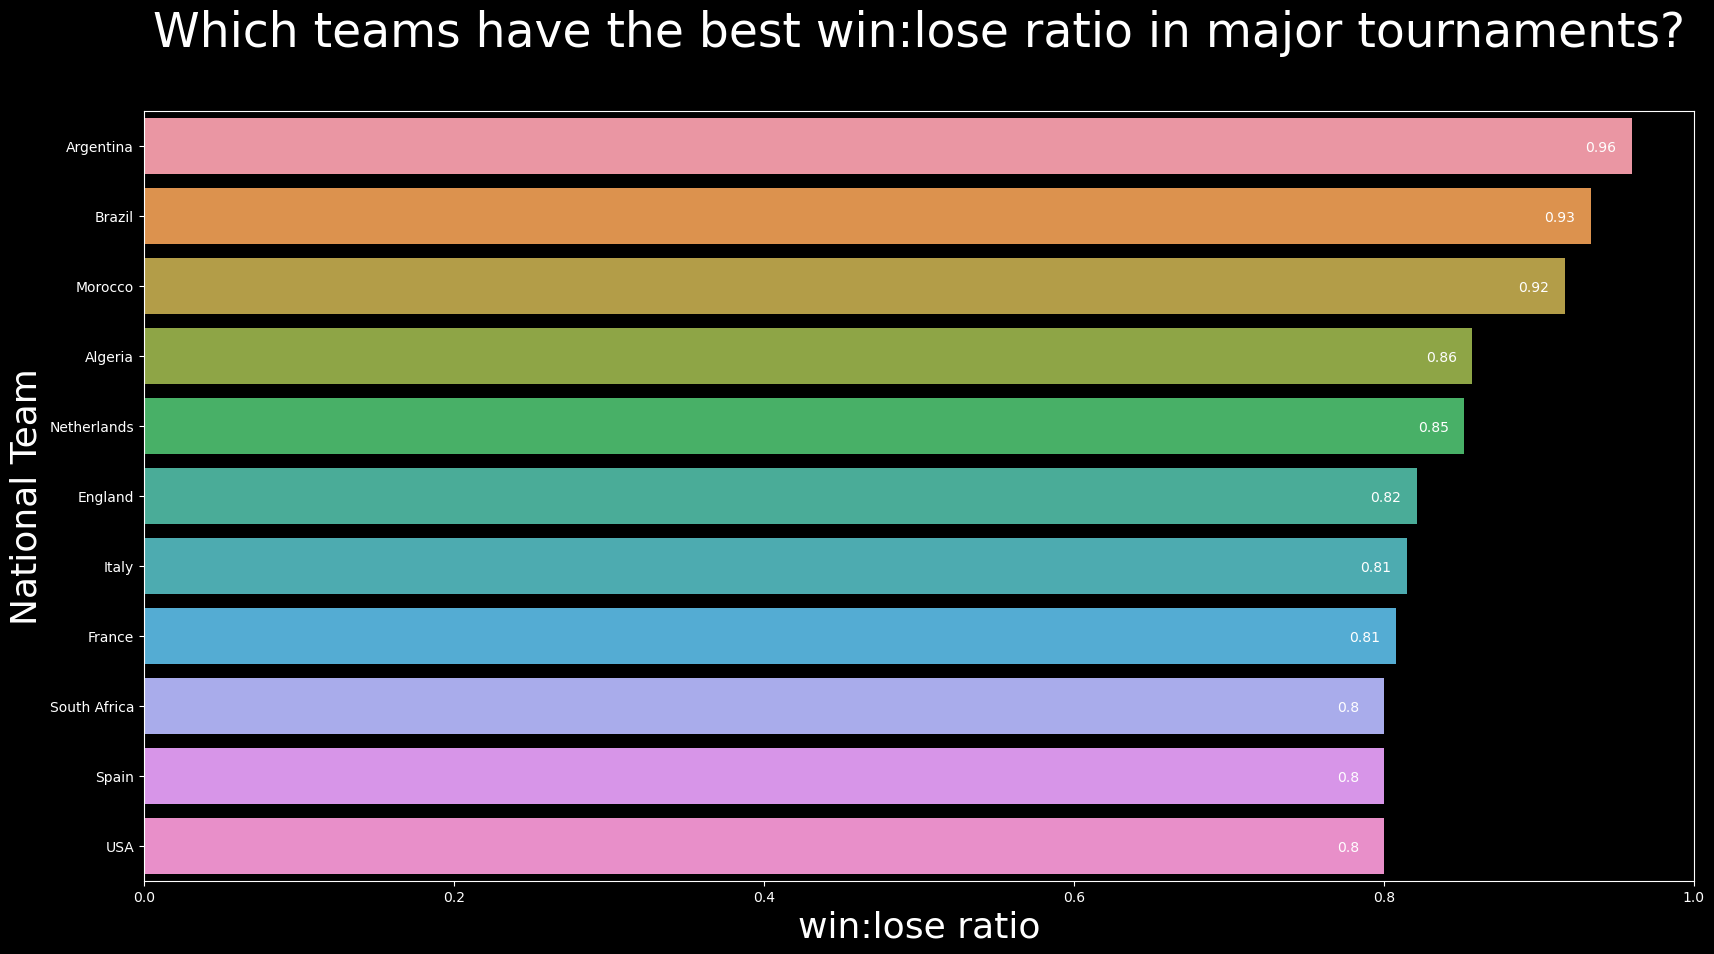

In [26]:
""" This code creates a bar plot using the Seaborn library to display the top 11 teams with 
the highest win-lose ratio in major tournaments. The figure size is set to 20x10, and the title, 
x-label, and y-label are all adjusted to the desired font size. The x-limit is set to 1, and 
the value labels for each team are annotated. Lastly, the plot_1_winner DataFrame is described."""

plt.figure(figsize=(20,10))
# barplot showing top 11 teams with win_lose_ratio
ax = sns.barplot(x=plot_1_winner[:11]['win_lose_ratio'],
                 y=plot_1_winner[:11].index)
ax.set_title('Which teams have the best win:lose ratio in major tournaments?\n', size=34)
ax.set_xlabel(xlabel='win:lose ratio', size=26)
ax.set_ylabel(ylabel='National Team', size=26)
ax.set_xlim(right=1)

# Annotate value labels to each team
i = 0
for index, value in plot_1_winner.iterrows(): 
    plt.annotate(float("{:.2f}".format(value['win_lose_ratio'])), xy=(value['win_lose_ratio']-0.03, i+0.075), color='white')
    i += 1
plot_1_winner.describe() 

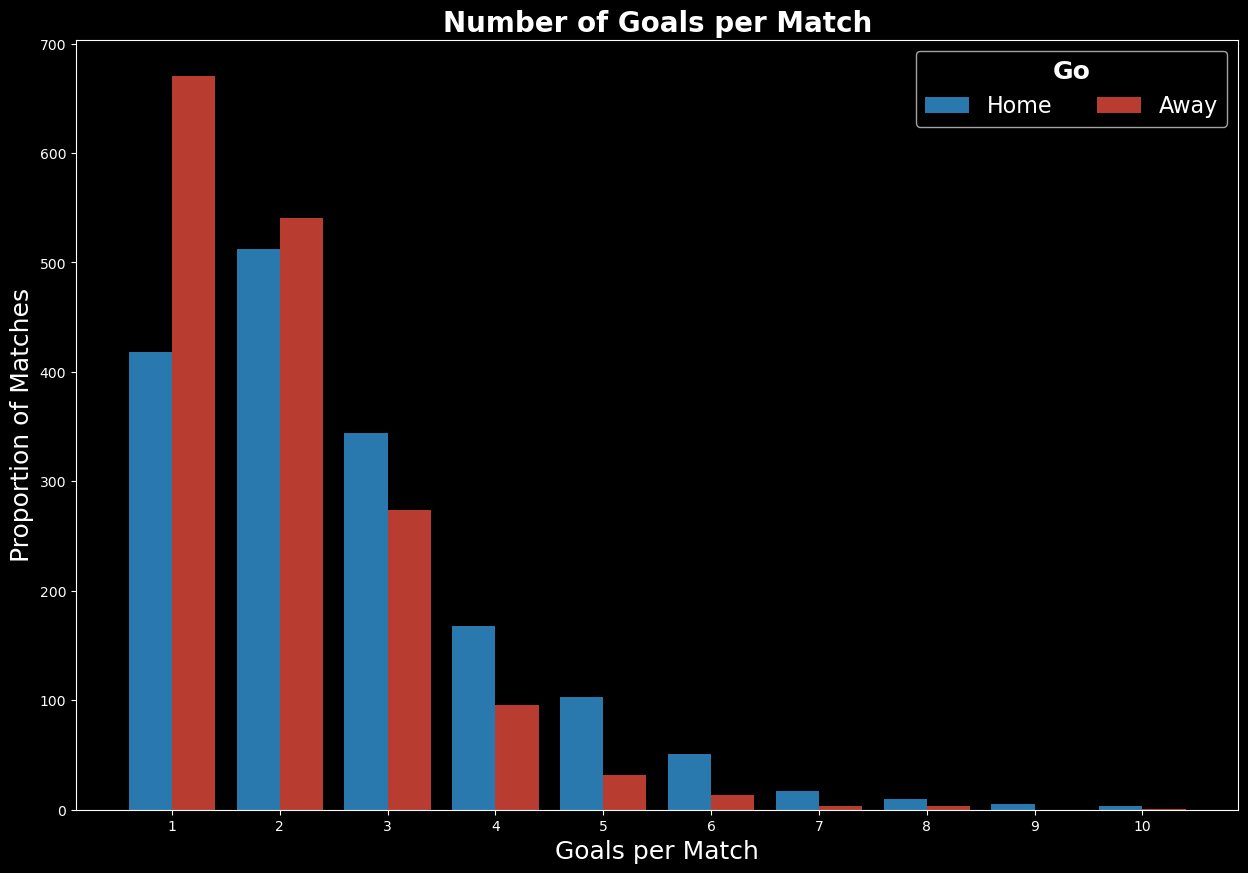

In [27]:
# mean of goals scored per match for both teams 
means = m_2[['home_score','away_score']].mean()

plt.figure(figsize=(15,10))
# plot histogram of actual goals
plt.hist(m_2[['home_score', 'away_score']].values, range(11), alpha=0.8,
         label=['Home', 'Away'], color=["#3498db", "#e74c3c"])  

# setting the legend in upper right corner
leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Go", prop = {'size':'18', 'weight':'bold'})

# adding 10 xticks 
plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(1,11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()

<AxesSubplot:xlabel='home_score', ylabel='points_home_team'>

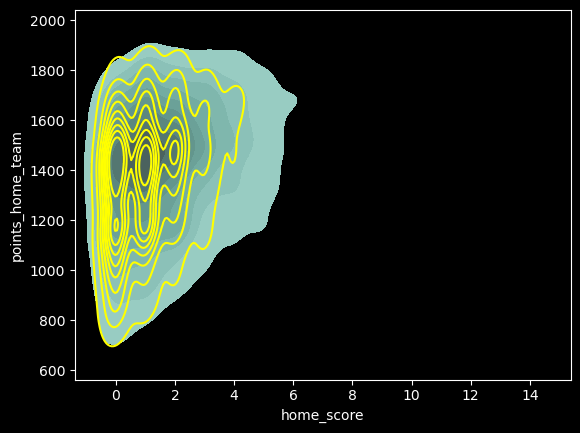

In [28]:
"""This code snippet uses seaborn's kdeplot to plot two distributions on the same graph. 
The first distribution uses the home_score and points_home_team data from the m_2 dataframe 
and the second distribution uses away_score and points_away_team from the same dataframe. 
The first distribution is filled in and the second is colored yellow."""

sns.kdeplot(x=m_2["home_score"],y=m_2["points_home_team"], fill=True)
sns.kdeplot(x=m_2["away_score"],y=m_2["points_away_team"], color="Yellow") 

# Predictive ML models 

In [29]:
"""Set of imports for a machine learning project. The imports cover preprocessing, 
metrics, feature selection, models, and model selection. All of the imports are from the 
sklearn library, which is a popular machine learning library. The imports show that the 
code is intending to use PCA, random forest classifier, adaboost classifier, SVC, pipeline, 
standard scaler, f1 score, confusion matrix, scikitplot, minmax scaler, onehot encoder, 
column transformer, accuracy score, precision score, recall score, confusion matrix, 
confusion matrix display, f1 score, roc auc score, random forest classifier, SVC, 
KNeighbors classifier, mutual info classif, logistic regression, and grid search cv."""

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 

In [30]:
# setting the target variable 'win'
target = 'win' 
X = m_2.drop([target,'date', 
              'home_score', 'away_score','home_team','away_team',
              'winner', 'loser', 'tournament'], axis=1) 
y = m_2[target] 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)  

In [32]:
"""This code is using NumPy and Scikit-learn to create a preprocessor 
for a dataset that has both numerical and categorical features. 
A MinMaxScaler is used to scale the numerical features, 
and a OneHotEncoder is used to encode the categorical feature. 
Four different classifiers are then defined and stored in a list."""
num_cols = np.array(X.select_dtypes(include = np.number).columns)
cat_cols = ["neutral"]

num_trans = MinMaxScaler()
cat_trans = OneHotEncoder(drop = "first")
preproc = make_column_transformer(
            (num_trans, num_cols),
            (cat_trans, cat_cols))

clasifiers = [LogisticRegression(class_weight='balanced'),
              RandomForestClassifier(class_weight='balanced'),
              SVC(),
              KNeighborsClassifier()]

In [33]:
"""This code iterates through a list of classifiers and creates a pipeline for each one. 
It then creates a GridSearchCV object with a 5-fold cross validation, and an accuracy scoring metric. 
The GridSearchCV object is then used to fit the training data, 
and the best score for each classifier is printed. 
This code is useful for testing the performance of a variety of classifiers for a given dataset."""
for clasifier in clasifiers: 
    pipe = make_pipeline(preproc, clasifier)
    grid = GridSearchCV(estimator=pipe, param_grid={}, cv=5, scoring="accuracy")
    grid.fit(X_train, y_train) 
    
    print(f"Train score for {clasifier}: {grid.best_score_}\n") 

Train score for LogisticRegression(class_weight='balanced'): 0.5816928738708598

Train score for RandomForestClassifier(class_weight='balanced'): 0.5171662763466042

Train score for SVC(): 0.5833255269320843

Train score for KNeighborsClassifier(): 0.5147474071595852



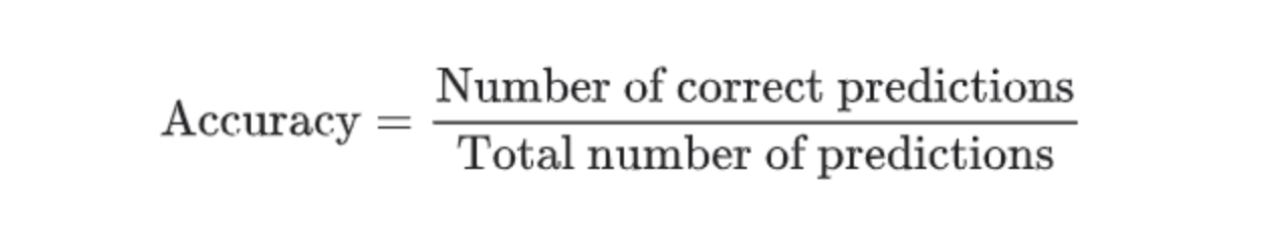

## Hyperparameter tuning

In [34]:
""" This code is creating a logistic regression classifier and then performing a grid search 
with a 5-fold cross-validation to find the best combination of parameters. 
The parameters being used are "logisticregression__C" with a range of 0.1, 1, 4, and 10. 
The best score and best parameters are then printed."""
param_grid_logreg = {"logisticregression__C" : [0.1, 1, 4, 10]}

clasifier =  LogisticRegression(max_iter=1000, class_weight='balanced')
pipe = make_pipeline(preproc, clasifier) 

grid_logreg = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_logreg,
    cv=5,
    scoring="accuracy")
grid_logreg.fit(X_train, y_train)

print("Best score :", grid_logreg.best_score_)
print("Best params :", grid_logreg.best_params_)  

Best score : 0.5898527935764469
Best params : {'logisticregression__C': 0.1}


## Confusion Matrix

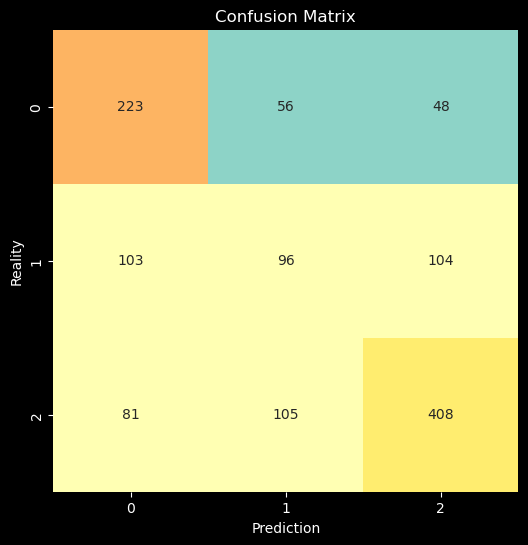

In [35]:
"""This code creates a visual representation of the confusion matrix 
generated by the grid_logreg model when predicting y_train using X_train. 
The confusion matrix is displayed using a heatmap where colors indicate 
the magnitude of the values. The figure size and labels are also customized."""

cm = confusion_matrix(y_train, grid_logreg.predict(X_train), labels = grid_logreg.classes_)
plt.figure(figsize =(6,6))
sns.heatmap(cm, annot=True, fmt='d',cmap="Set3",cbar=False)
plt.xlabel("Prediction") 
plt.ylabel("Reality")  
plt.title("Confusion Matrix")
plt.show()


In [36]:
# Balance or not to balance -> let's balance -> class_weight='balanced'
y.value_counts(normalize=True) 

2    0.497244
0    0.265156
1    0.237600
Name: win, dtype: float64

## Testing the Logistic Regression model on test data

In [37]:
"""This code calculates the accuracy score of a machine learning model (logistic regression) 
by comparing the predicted values (y_pred) with the true values (y_test) 
and prints the accuracy score to 4 decimal points in percent."""

accuracy = accuracy_score(y_test, y_pred=grid_logreg.predict(X_test))
print('Accuracy score:', round(accuracy*100, 4), "%") 

Accuracy score: 60.6357 %


# Making the real prediction model for the matches of your choice !

In [38]:
"""Creating a list of unique values from the away_team and home_team columns in the m_2 dataframe. 
It then combines the two lists into one and creates a Series object from it. 
Lastly, the .unique() method is used to return only the unique values from the Series object, 
which is then assigned to list_countries_unq."""

list_1 = list(m_2.away_team.unique())
list_2 = list(m_2.home_team.unique())
list_countries_unq = pd.Series(list_1+list_2).unique()
list_countries_unq

array(['Sweden', 'Iceland', 'Costa Rica', 'Spain', 'Switzerland',
       'Serbia', 'Hungary', 'Republic of Ireland', 'Wales', 'Kosovo',
       'Greece', 'Andorra', 'Malta', 'Bosnia and Herzegovina', 'Poland',
       'Austria', 'Northern Ireland', 'Israel', 'Czech Republic',
       'Kazakhstan', 'Albania', 'England', 'Belgium', 'Croatia', 'France',
       'Montenegro', 'Luxembourg', 'Armenia', 'Georgia', 'San Marino',
       'Ukraine', 'Germany', 'Russia', 'Turkey', 'Bulgaria', 'Finland',
       'Moldova', 'Faroe Islands', 'Latvia', 'Italy', 'Norway', 'Romania',
       'Scotland', 'Slovakia', 'Belarus', 'Lithuania', 'Portugal',
       'Azerbaijan', 'Estonia', 'North Macedonia', 'Liechtenstein',
       'Gibraltar', 'Mexico', 'Namibia', 'Peru', 'Chile', 'Ecuador',
       'Cameroon', 'Sierra Leone', 'Senegal', 'Algeria', 'Sudan',
       'Venezuela', 'Bolivia', 'Cyprus', 'Panama', 'Nicaragua', 'Chad',
       'Netherlands', 'Denmark', 'Slovenia', 'Zambia', 'Madagascar',
       'Uzbekistan', 

In [39]:
"""Using the BeautifulSoup and requests libraries to scrape a web page from the Internet. 
It also uses the IPython display module to display an image. The code is pulling a list of 
countries from a Series object and creating a list of unique values from that Series object."""

from bs4 import BeautifulSoup
import requests
import urllib.request
from IPython.display import Image

In [40]:
X 

,rank_home_team,points_home_team,rank_away_team,points_away_team,neutral
1,174.0,961.23,25.0,1553.33,True
3,107.0,1187.01,25.0,1553.33,True
4,41.0,1475.00,62.0,1384.41,True
5,74.0,1330.51,62.0,1384.41,True
6,16.0,1627.48,31.0,1503.59,False
...,...,...,...,...,...
2309,24.0,1559.54,12.0,1645.64,True
2310,1.0,1841.30,28.0,1530.30,True
2311,1.0,1841.30,112.0,1169.96,True
2312,22.0,1563.50,7.0,1715.22,True


In [41]:
"""Using functions to segment and manipulate data, and then the grid_logreg 
to predict the winner of the match between the two teams. The code then prints 
the winner and the image of the food they will be celebrating with. """

def is_winner(home_team, away_team):
        # Subset the data for the home team
        home_team_data = ranking[ranking['country_full'] == home_team][['rank', 'total_points']]

        # Subset the data for the away team
        away_team_data = ranking[ranking['country_full'] == away_team][['rank', 'total_points']]

        # Merge the datasets
        combined_data = pd.merge(home_team_data, away_team_data, how="cross")
        new_combined_data_columns = {
            'rank_x': 'rank_home_team',
            'total_points_x': 'points_home_team',
            'rank_y': 'rank_away_team',
            'total_points_y' : 'points_away_team'
        }
        combined_data.rename(columns=new_combined_data_columns, inplace=True)
        combined_data['neutral'] = True
        # prediction
        pred = grid_logreg.predict(combined_data)[0]

        # translating into human language 
        if pred == 0:
            winner = away_team
            print(f"Sorry {home_team}, better luck next time :( {away_team} winns!")
            # Request the web page
            response = requests.get(f"https://www.google.com/search?tbm=isch&q={winner}+partyfood")

            # Parse the webpage
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find all the images
            images = soup.findAll('img')

            # Print the 2th image
            image = images[2]['src']

            # Display the 2th image
            print("Winning team is going to celebrate with this food for dinner: ")
            return Image(f"{image}.svg.png") 
        if pred == 1:
            print("Seems like both teams are equally good (or bad -.-)  it's a draw")
            print("Get ready for penalties!")
        if pred == 2:
            winner = home_team
            print(f"Sorry {away_team}, better luck next time :( {home_team} winns!")
            # Request the web page
            response = requests.get(f"https://www.google.com/search?tbm=isch&q={winner}+partyfood")

            # Parse the webpage
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find all the images
            images = soup.findAll('img')

            # Print the 2th image
            image = images[2]['src']
            print("Winning team is going to celebrate with this food for dinner: ")
            # Display the 2th image
            return Image(f"{image}.svg.png") 

Image created using OpenAI


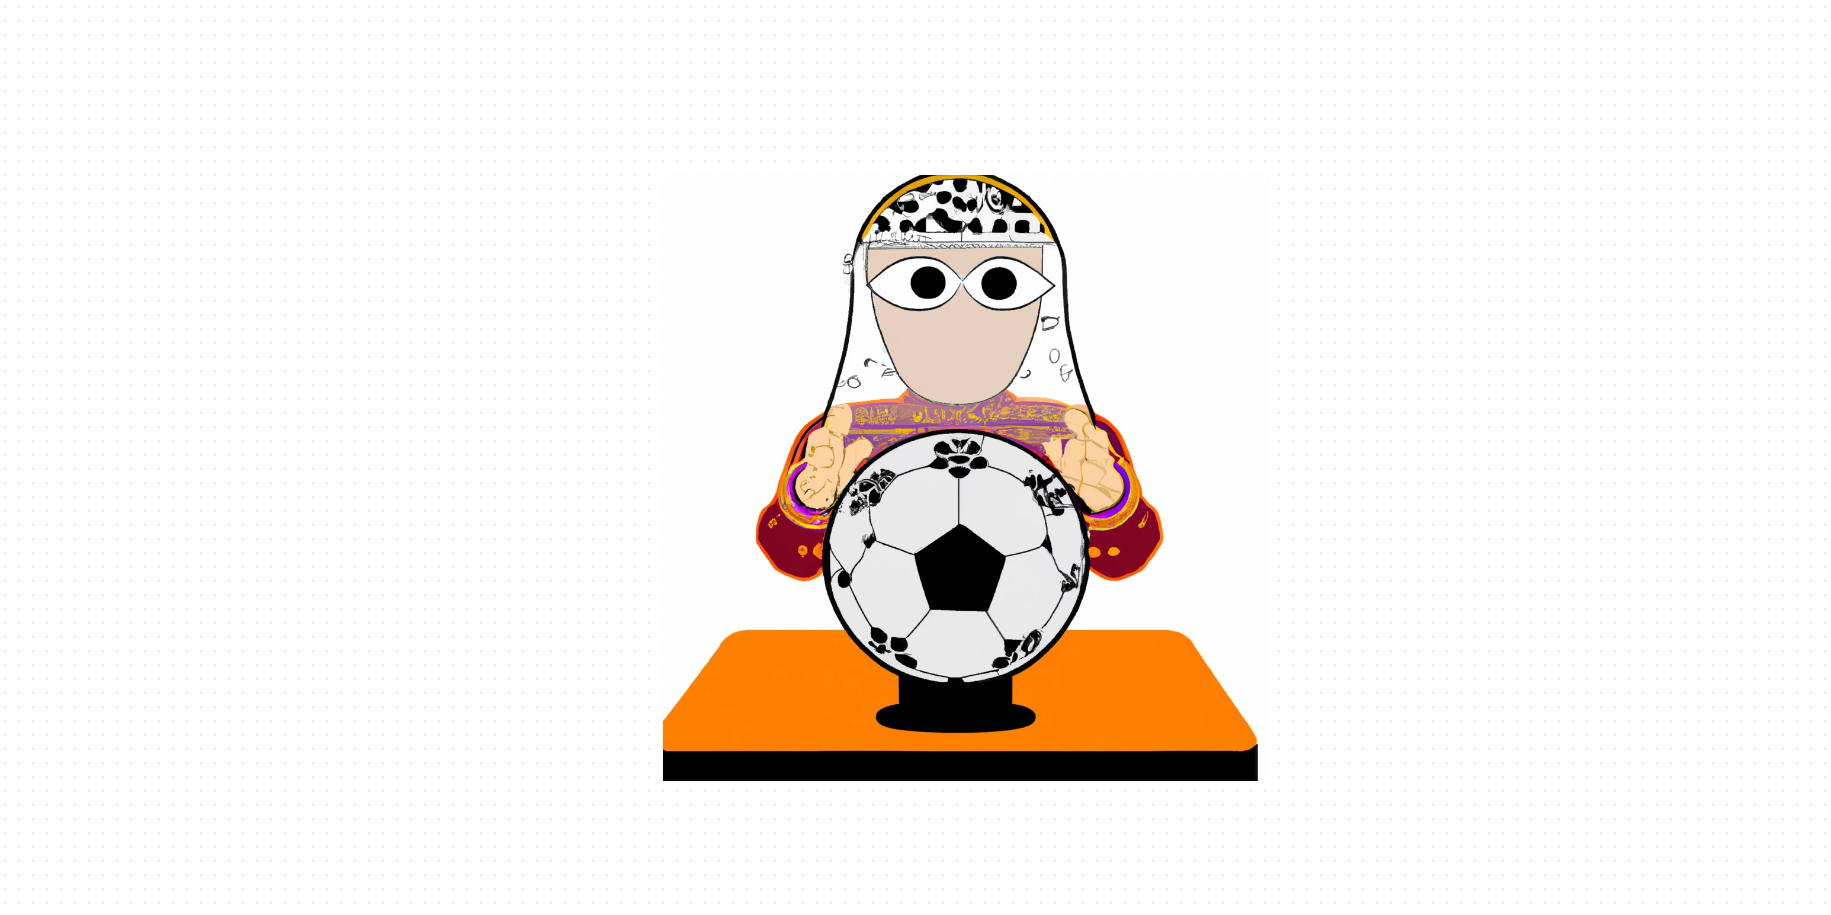

Test the function with two teams of your choice!

Sorry Morocco, better luck next time :( Croatia winns!
Winning team is going to celebrate with this food for dinner: 


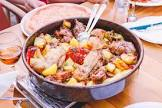

In [42]:
is_winner("Morocco","Croatia") 

Final project at Nod Bootcamp, Stockholm October-December 2022.